In [1]:
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse_log_file(input_file, output_file):
    """
    Parse training log file and extract validation loss data into CSV.
    
    Args:
        input_file (str): Path to input log file
        output_file (str): Path to output CSV file
    """
    # Compile regex pattern to match validation loss lines
    pattern = r'step:(\d+)/\d+ val_loss:([\d.]+) train_time:(\d+)ms'
    
    # Store the extracted data
    validation_data = []
    
    # Read and process the log file
    with open(input_file, 'r') as f:
        for line in f:
            if 'val_loss' in line:
                match = re.match(pattern, line.strip())
                if match:
                    step = int(match.group(1))
                    val_loss = float(match.group(2))
                    train_time = int(match.group(3))
                    validation_data.append([step, val_loss, train_time])
    
    # Write to CSV file
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        # Write header
        writer.writerow(['step', 'val_loss', 'train_time'])
        # Write data
        writer.writerows(validation_data)


In [3]:
# for every .txt file in logs/, run parse_log_file on it
import os
for file in os.listdir('logs/'):
    if file.endswith('.txt'):
        parse_log_file(f'logs/{file}', f'logs/{file.replace('.txt', '.csv')}')

00cfd179-31f48b80.csv
c1930484-31f48b80.csv
cb424576-e77502d3.csv
ab2d5034-e77502d3.csv
03246a0d-e77502d3.csv
reference.csv
8f3b0bb4-31f48b80.csv
c083d2d4-31f48b80.csv
55db2b0c-e77502d3.csv
ab2d5034-31f48b80.csv


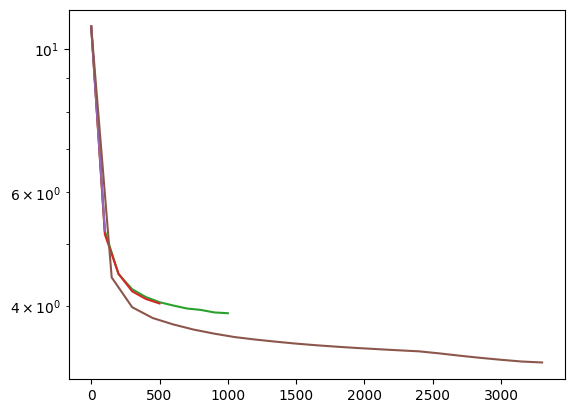

In [4]:
list_of_results = []    

for file in os.listdir('logs/'):
    if file.endswith('.csv'):
        df = pd.read_csv(f'logs/{file}')
        df['file'] = file.replace('.csv', '')
        list_of_results.append(df)

        # plot the validation loss by train time for each file
        plt.plot(df['step'], df['val_loss'], label=file)
        print(file)
plt.yscale('log')
plt.show()


In [5]:
# the first line of the log files is always the hyperparameters
# here is an example:
# --num_iterations 1000 --embedding_lr 0.1 --lm_head_lr 0.002 --muon_lr 0.02 --scalar_lr 0.01 --muon_momentum 0.95 --warmdown_iters 926

# extract the hyperparameters from the first line of the log file
# and make a df with the hyperparameters and the corresponding validation loss at step 1000

records = []

for file in os.listdir('logs/'):
    if file.endswith('.txt'):
        with open(f'logs/{file}', 'r') as f:
            first_line = f.readline()
            hps = re.findall(r'--(\w+)\s+(\S+)', first_line)
            hps = dict(hps)
            hps['file'] = file.replace('.txt', '')
            records.append(hps)

hyperparams_df = pd.DataFrame(records)


In [6]:
results_df = pd.concat(list_of_results)

# i implemented an early stop at step 500 if the validation loss was really bad
# add a check to see if the validation loss exists at step 500 but not step 1000
# if so, add a new row to the results_df with the validation loss at step 500 copied to step 1000

# all_runs = results_df.loc[results_df['step'] == 500, 'file'].unique()
# all_runs_that_did_not_early_stop = results_df.loc[results_df['step'] == 1000, 'file'].unique()
# early_stopped_runs = set(all_runs) - set(all_runs_that_did_not_early_stop)

# create a df with exactly one row for each early stopped run
# that has the validation loss at step 500 copied to step 1000
# early_stop_records = []
# for run in early_stopped_runs:
#     early_stop_records.append(
#         {
#             "file": run,
#             "step": 1000,
#             "val_loss": 10
#         }
#     )
# early_stop_df = pd.DataFrame(early_stop_records)
# results_df = results_df.loc[results_df['step'] == 1000, :]


full_runs = results_df.loc[results_df['step'] == 500, 'file'].unique()
full_runs_df = results_df.loc[results_df['file'].isin(full_runs), :]

# results_df = pd.concat([results_df, early_stop_df])
results_df = full_runs_df
results_df = results_df.loc[results_df['step'] == 500, :]

# join on file
joined_df = hyperparams_df.merge(results_df, on='file', how='inner')
joined_df.head(10).sort_values(by='val_loss')

/tmp/ipykernel_814925/896509705.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(list_of_results)


,num_iterations,val_loss_every,orthogonalize_every,file,step,val_loss,train_time
0,3300,100,10,ab2d5034-e77502d3,500,4.0411,308399
1,3300,100,10,cb424576-e77502d3,500,4.0594,306711


In [7]:
joined_df.loc[joined_df['val_loss'] <= 3.28, :].sort_values(by='train_time')

,num_iterations,val_loss_every,orthogonalize_every,file,step,val_loss,train_time


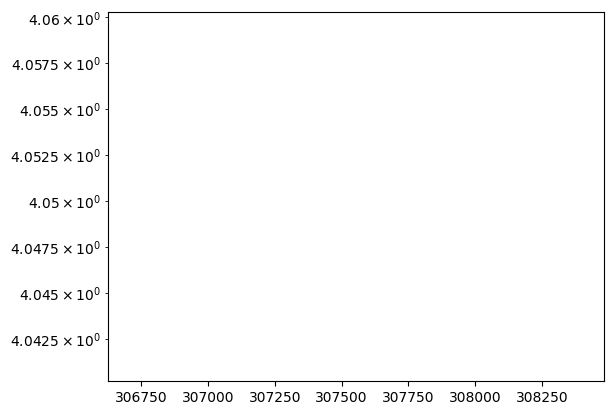

In [8]:
# for each full run, plot the validation loss by train_time
for file in full_runs:
    df = joined_df.loc[(joined_df['file'] == file) & (joined_df['step'] >= 00), :]
    # if the file is called "reference_run", add a special label
    # if file == "reference_run":
    if file == "98e80c8f-3e2745af":
        plt.plot(df['train_time'], df['val_loss'], label=file, linestyle='--')
    else:
        plt.plot(df['train_time'], df['val_loss'], label=file)
plt.yscale('log')
# plt.legend()
plt.show()


In [9]:
# import numpy as np
# import pandas as pd
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import Matern
# from scipy.stats import norm

# df = joined_df
# df = df.dropna()
# sweep_vars = ['embedding_lr', 'muon_lr']

# X = df[sweep_vars].values  # Hyperparameters
# y = df["val_loss"].values - 10  # Validation losses
# kernel = Matern(nu=2.5)
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
# gp.fit(X, y)

# n_samples = 10000  # Number of new settings to sample
# def sample_log_uniform(min_val, max_val, size=1):
#     """Sample log-uniformly between min_val and max_val."""
#     return np.exp(np.random.uniform(np.log(min_val), np.log(max_val), size))

# # Define the min and max for each hyperparameter
# # Replace these with the actual ranges for your parameters
# hyperparameter_ranges = {
#     'embedding_lr': (0.0001, 0.5),
#     # 'lm_head_lr': (0.0002, 0.2),
#     'muon_lr': (0.001, 1),
#     # 'scalar_lr': (0.001, 1),
# }

# # Number of samples to generate
# n_samples = 100

# # Sample log-uniformly for each hyperparameter
# samples = {
#     param: sample_log_uniform(min_val, max_val, n_samples)
#     for param, (min_val, max_val) in hyperparameter_ranges.items()
# }
# X_new = np.array(list(samples.values())).T
# y_mean, y_std = gp.predict(X_new, return_std=True)

# best_loss = y.min()
# improvement = best_loss - y_mean
# Z = improvement / y_std
# EI = improvement * norm.cdf(Z) + y_std * norm.pdf(Z)

# # Select the top-k hyperparameters with the highest expected improvement
# k = 10
# top_k_indices = np.argsort(EI)[-k:]
# top_k_hyperparameters = X_new[top_k_indices]

# # Display selected hyperparameters
# top_k_df = pd.DataFrame(top_k_hyperparameters, columns=sweep_vars)


In [10]:
# top_k_df
